In [1]:
from diffmain import *
from DataL import *
from torchsummary import summary
from simpleAE import myAE
import glob
import sys
import os
import re
import torch    
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pdb
from tqdm import tqdm
from torch.utils.data import DataLoader, random_split
from torch.utils.data.distributed import DistributedSampler


In [2]:
seed = 112233
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


380


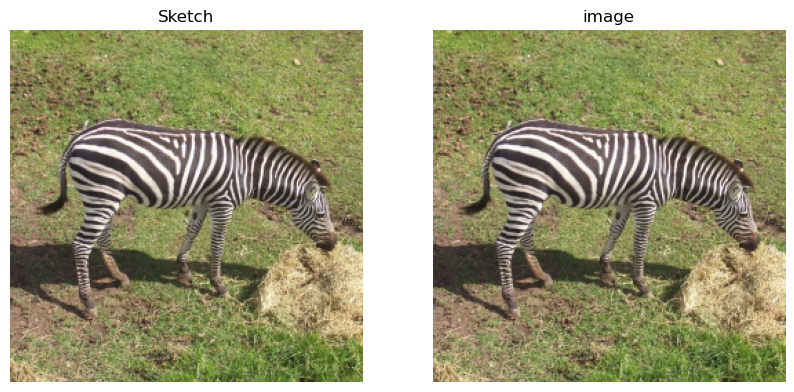

In [3]:
transform = transforms.ToTensor()
SketchySet = get_imageset("tiger", "cat", "dog", "zebra", transform = transform, image = True, rgb = True, size = 256)

dataset_size = len(SketchySet)
train_size = int(0.95 * dataset_size)
val_size = dataset_size - train_size

# Splitting the dataset
train_dataset, val_dataset = random_split(SketchySet, [train_size, val_size])

# Creating the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=5, shuffle=False, num_workers=1, pin_memory=True)

print(len(train_dataset))

i=random.randint(0,len(SketchySet)-1)
sk,im = SketchySet[i]

# Convert the tensors back to numpy arrays
sk = sk.numpy()
im = im.numpy()

sk=np.array(sk).transpose((1,2,0))
im=np.array(im).transpose((1,2,0))
#print(im)
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(sk)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(im)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()

In [5]:
model = myAE(3, 100, variation = True).to(device)
#summary(model, (3, 256, 256))

In [ ]:
n_epochs = 100
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.7)  # Decays the learning rate by a factor of 0.1 every 30 epochs

train_losses = []
val_losses = []
for epoch in tqdm(range(n_epochs)):
    model.train()
    train_loss = 0
    val_loss = 0
    for image, sketch in train_loader:
        optimizer.zero_grad()

        image = image.to(device)
        out, mu, logvar = model(image)
        #print("MU", mu.shape)
        loss = torch.mean(model.loss_function(out, image, mu, logvar))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    for image, sketch in val_loader:
        image = image.to(device)
        sketch = sketch.to(device)
        
        val_out, val_mu, val_logvar = model(image)
        
        loss = torch.mean(model.loss_function(val_out, image, val_mu, val_logvar))
        val_loss += loss.item()
        
    scheduler.step()
    train_loss = train_loss/len(train_loader)
    val_loss = val_loss/len(val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    if epoch % 10 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))
        print('Epoch: {} \tvalidation Loss: {:.6f}'.format(epoch, val_loss))

  1%|▉                                                                                        | 1/100 [00:03<06:06,  3.71s/it]

Epoch: 0 	Training Loss: 60.624846
Epoch: 0 	validation Loss: 57.479026


  4%|███▌                                                                                     | 4/100 [00:14<05:41,  3.56s/it]

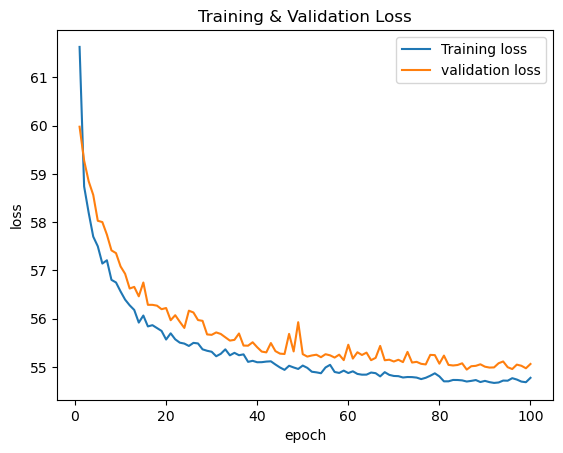

In [7]:
plt.plot(range(1,len(train_losses)+1), train_losses, label='Training loss')
plt.plot(range(1,len(val_losses)+1), val_losses, label='validation loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


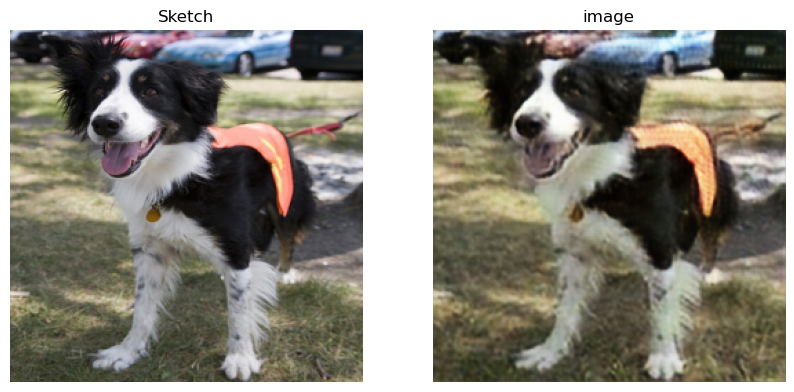

In [8]:
image, sketch = next(iter(train_loader))
image = image[4].unsqueeze(0)

image = image.to(device)
print(image.size())
x_hat, mu, logvar = model(image)
print(x_hat.size())

image = image.cpu().detach().numpy()
x_hat = x_hat.cpu().detach().numpy()

fig, ax = plt.subplots(1,2,figsize=(10,5))
image = image.squeeze(0).transpose((1,2,0))
x_hat = x_hat.squeeze(0).transpose((1,2,0))
ax[0].imshow(image)
ax[0].set_title('Sketch')
ax[0].axis('off')

ax[1].imshow(x_hat)
ax[1].set_title('image')
ax[1].axis('off')

plt.show()

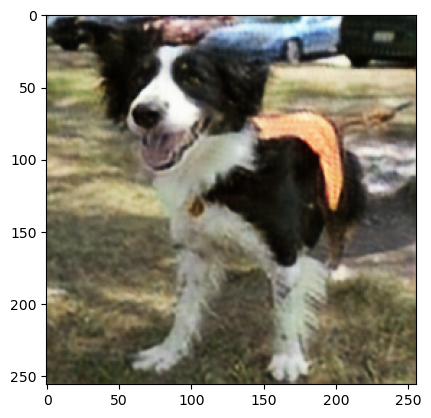

In [9]:
seed = 0
z = model.reparametrize(mu, logvar+1)
samples = model.decoder(z)
samples = samples.cpu().detach().numpy()
samples = samples.squeeze(0).transpose((1,2,0))

plt.imshow(samples)

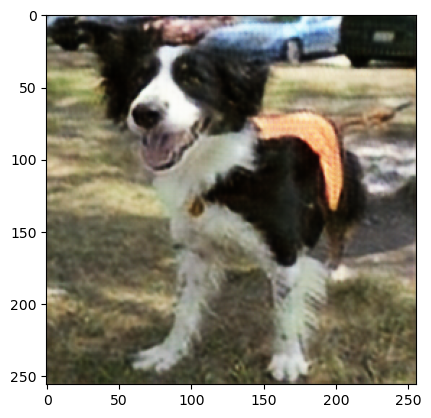

In [10]:
seed = 1
z = model.reparametrize(mu, logvar+1)
samples = model.decoder(z)
samples = samples.cpu().detach().numpy()
samples = samples.squeeze(0).transpose((1,2,0))

plt.imshow(samples)